In [2]:
%load_ext autoreload
%autoreload 2

import time
from collections import deque, Counter

import numpy as np

import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image

from dm_control import mjcf
from dm_control import viewer

import torch
import torch.nn as nn
import torch.nn.init as nn_init
import torch.nn.functional as F
import torch.optim as optim

import gymnasium as gym

from multi_agent_cartpole3d import MultiAgentCartPole3D
from rendering import display_video




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(3, 8)
(3, 8)


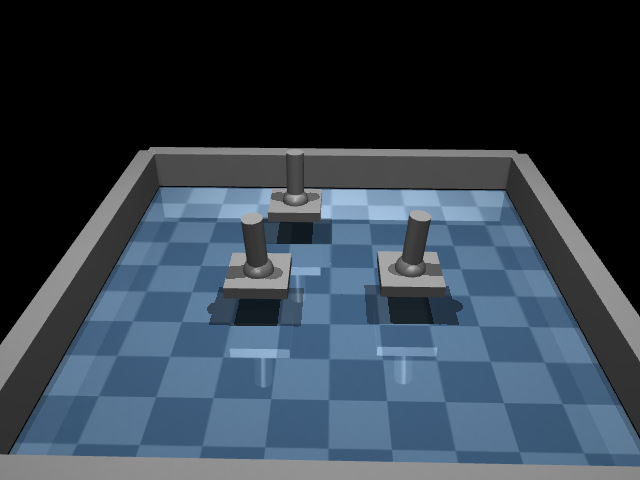

In [11]:
def make_multi_agent_cart_pole_env():
    return MultiAgentCartPole3D(
        nr_carts=3,
        cart_size=0.25,
        force_magnitude=500,
        physics_steps_per_step=1,
        reset_position_radius=0.75,
        reset_randomize_position_angle_offset=True,
        reset_position_randomization_magnitude=0.3,
        reset_hinge_randomization_magnitude=0.05,
        slide_range=2,
        hinge_range=0.8,
        time_limit=10.0,
        step_reward_function=lambda time, action, state, prev_state: 0,
        out_ouf_range_reward_function=lambda time, action, state: -10 + time * 3,
        time_limit_reward_function=lambda time, action, state: 10000,
    )

cartpole3d_env = make_multi_agent_cart_pole_env()
cartpole3d_env.reset(seed=None)
obs = None
for _ in range(100):
    obs, _, _, _, _ = cartpole3d_env.step(np.array([0.0, 0.0] * cartpole3d_env.nr_carts))

print(cartpole3d_env.get_observations().shape)
print(obs.shape)
cartpole3d_env.render(camera_id=1)

In [58]:
device = torch.device('cuda:0' if False and torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

eps = 1e-6

seed = time.time_ns() % (2**32)
np.random.seed(seed)
torch.manual_seed(seed)
print(f'seed is {seed}')

def step_reward(time, action, state, prev_state):
    reward = 0.0

    reward += 0.15
    
    reward += -0.0 * time

    reward += -0.0 * np.linalg.norm(state[0:2])  # slide distance
    reward += -0.0 * np.linalg.norm(state[2:4])  # hinge distance
    
    reward += -0.1 * (np.linalg.norm(state[0:2]) - np.linalg.norm(prev_state[0:2]))
    reward += -1.0 * (np.linalg.norm(state[2:4]) - np.linalg.norm(prev_state[2:4]))
    
    return reward

env = CartPole3D(
    nr_movement_dimensions=2,
    cart_size=0.25,
    force_magnitude=5000,
    physics_steps_per_step=1,
    reset_randomization_magnitude=0.1,
    slide_range=1.5,
    hinge_range=1,
    time_limit=100.0,
    step_reward_function=step_reward, # (time if np.any(np.abs(np.array([1.0, 2.0, 4.0, 6.0, 8.0, 10.0]) - time) < 0.002) else 0) + ((-10) if np.linalg.norm(action) > 0.99 else 0), #-np.linalg.norm(state[:4]) + time / 2,
    out_ouf_range_reward_function=lambda time, action, state: 0,
    time_limit_reward_function=lambda time, action, state: 100,
)
# env = gym.make("CartPole-v1")

action_size = env.action_space.shape[0]
obs_size = env.observation_space.shape[0]

gamma = 0.0

action_dist_sd = 0.15

minimum_learning_episodes = 10
timestep_discard_limit = 1


def main():
    saved_actions = []
    saved_log_probs = []
    saved_state_preds = []
    saved_state_targets = []
    rewards = []
    
    def stringify_np_array(arr):
        return ", ".join([f"{x:> 2.4f}" for x in arr])
    
    def init_policy():
        return StateModelFnnPolicy(
            action_size=action_size,
            state_size=obs_size,
            in_state_embedding_sizes=[
                64,
                64,
                64
            ],
            action_pred_hidden_sizes=[
                32,
                16, # 32 worked
            ],
            state_pred_hidden_sizes=[
                32,
            ],
        )    
    
    def select_action(mean_predictions, i_episode):    
        action_dist = torch.distributions.Normal(
            mean_predictions, 
            action_dist_sd # / (1 + i_episode / 30)
        )
        action = action_dist.sample()
        saved_log_probs.append(action_dist.log_prob(action))

        return action.detach().cpu().numpy()
    
    def finish_episode(policy, optimizer):
        R = 0
        policy_loss = []
        returns = deque()
        for r in rewards[::-1]:
            R = r + gamma * R
            returns.appendleft(R)
        returns = torch.tensor(returns)
        # print(stringify_np_array(returns))
        returns = (returns - returns.mean()) / (returns.std() + eps)
        # print(stringify_np_array(returns))
        
        for log_prob, R in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * R)

        # print(saved_log_probs)
        
        optimizer.zero_grad()

        policy_loss = 10.0 * torch.cat(policy_loss).mean()
        
        state_pred_loss = 1.0 * F.mse_loss(torch.stack(saved_state_preds), torch.stack(saved_state_targets))
        
        action_loss = 0.5 * torch.stack(saved_actions).norm(dim=-1).pow(2).mean()
        
        #print(f'{" " * 83}  policy | state pred | action loss:  {policy_loss.item():0> 9.6f}{" " * 7}   |  {state_pred_loss.item():0> 9.6f}{" " * 7}   |   {action_loss.item():0> 9.6f}')
        print(f'{" " * 83}  policy | state pred | action loss:  {policy_loss.item(): >9.6f}{" " * 7}   |   {state_pred_loss.item(): >9.6f}{" " * 7}   |   {action_loss.item(): >9.6f}')


        combined_loss = policy_loss + state_pred_loss + action_loss
        combined_loss.backward()
        optimizer.step()
        
        # print(stringify_np_array(rewards))
        
        del rewards[:]
        del saved_log_probs[:]
        del saved_state_preds[:]
        del saved_state_targets[:]
        del saved_actions[:]
        
        return returns
        
    print(f'Model has {sum(p.numel() for p in init_policy().parameters() if p.requires_grad)} parameters')
    
    best_total_reward = 0

    for i_trial in range(1000):
        print(f'=====  Trial nr {i_trial:>4}  =====')
        trial_best_reward = 0
        
        policy = init_policy()
        optimizer = optim.Adam(policy.parameters(), lr=1e-3)

        timestep = 0
        for i_episode in range(2000):
            if i_episode > minimum_learning_episodes and timestep < timestep_discard_limit:
                break
            
            state, _ = env.reset()
            ep_reward = 0
            action_pred_log = []
            info = {}
            
            max_timestep = 1000000
            for timestep in range(1, max_timestep):  # Don't infinite loop while learning
                action_pred, state_pred = policy(torch.tensor(state).float())
                
                action = select_action(action_pred, i_episode)
                
                state, reward, done, truncated, info = env.step(action)

                saved_state_preds.append(state_pred)
                saved_state_targets.append(torch.tensor(state).float())
                saved_actions.append(action_pred)
                
                action_pred_log.append(action_pred.detach().cpu().numpy())
                rewards.append(reward)
                ep_reward += reward
                
                if done:
                    break
            
            
            if timestep == max_timestep - 1:
                info['termination_reason'] = 'timestep_limit_reached' 

            if ep_reward >= trial_best_reward:
                trial_best_reward = ep_reward
            
            if ep_reward >= best_total_reward:
                best_total_reward = ep_reward
                torch.save(policy, 'best.pt')
            
            if i_episode % 1 == 0:
                    
                print(f'{i_episode:>4}   '
                      f'Total reward: {ep_reward:>7.2f} \t '
                      f'Time (Actions): {env.get_time():7.4f} ({timestep:>5})      '
                      f' {info["termination_reason"].split("_")[0]}\t     '
                      f'Pred mean | std | min | max:        '
                      f'{stringify_np_array(np.mean(action_pred_log, axis=0))}   |   '
                      f'{stringify_np_array(np.std(action_pred_log, axis=0))}   |   '
                      f'{stringify_np_array(np.min(action_pred_log, axis=0))}   |   '
                      f'{stringify_np_array(np.max(action_pred_log, axis=0))}')
    
            finish_episode(policy, optimizer)
            print()
        
            if False:
                print("Solved! "
                      "the last episode runs to {} time steps!".format(t))
                break
main()

seed is 2726636876
Model has 13946 parameters
=====  Trial nr    0  =====
   0   Total reward:    4.55 	 Time (Actions):  0.0780 (   39)       hinge	     Pred mean | std | min | max:         0.7797, -0.7604   |    0.1070,  0.1195   |    0.3406, -0.8592   |    0.9089, -0.1802
                                                                                     policy | state pred | action loss:  -0.531796          |   52.129597          |    0.605978

   1   Total reward:    4.13 	 Time (Actions):  0.0720 (   36)       hinge	     Pred mean | std | min | max:         0.9067, -0.8345   |    0.1138,  0.1413   |    0.2985, -0.9457   |    0.9637, -0.1698
                                                                                     policy | state pred | action loss:   1.740942          |   45.496117          |    0.775723

   2   Total reward:    4.02 	 Time (Actions):  0.0720 (   36)       hinge	     Pred mean | std | min | max:         0.9514, -0.8888   |    0.0864,  0.1264   |    0.4


KeyboardInterrupt



In [153]:
def main():
    def select_action(mean_predictions):    
        action_dist = torch.distributions.Normal(
            mean_predictions, 
            action_dist_sd
        )
        action = action_dist.sample()

        return action.detach().cpu().numpy()
    
    duration = 60 * 0.1   # (Seconds)
    framerate = 30  # (Hz)
    video = []
     
    last_switch = 0
    
    policy = torch.load('best.pt')

    if True:
        global env
        env = MultiAgentCartPole3D(
            nr_carts=8,
            cart_size=0.25,
            force_magnitude=500,
            physics_steps_per_step=1,
            reset_position_radius=0.75,
            reset_randomization_magnitude=0.1,
            slide_range=2,
            hinge_range=0.8,
            time_limit=10.0,
            step_reward_function=lambda time, action, state, prev_state: 0,
            out_ouf_range_reward_function=lambda time, action, state: -10 + time * 3,
            time_limit_reward_function=lambda time, action, state: 10000,
        )
    
    physics = env.physics
    
    state, _ = env.reset()
    print(env.get_observations())
    
    trace = []
    
    while physics.data.time < duration:
#         action_pred, state_pred = policy(torch.tensor(state).float())

#         action = select_action(action_pred)
        action = np.array([0.0, 0.0] * env.nr_carts)
        
        trace.append((state, action))
        state, reward, done, _, _ = env.step(action)
    
        if len(video) < physics.data.time * framerate:
            
            pixels = physics.render(width=640, height=480, camera_id=1)
            video.append(pixels.copy())
    
    trace_states = [t[0] for t in trace]
    trace_actions = [t[1] for t in trace]
    print(np.mean(trace_actions, axis=0), np.std(trace_actions, axis=0), np.min(trace_actions, axis=0), np.max(trace_actions, axis=0))
    return display_video(video, framerate)

main()

[[[ 8.23420430e-01 -9.56026082e-02 -9.52884544e-02 -5.97643361e-02]
  [ 4.76282723e-02  6.46474826e-02 -1.37443430e-01 -1.81207844e-01]]

 [[ 4.40161467e-01  5.02251189e-01 -8.57311396e-02 -6.22962638e-02]
  [ 2.65856620e-02 -1.40437931e-04  2.89012348e-01 -2.12460643e-03]]

 [[ 9.63829244e-02  7.04148819e-01 -8.49056473e-02  9.82645551e-02]
  [-5.74728444e-02 -1.41316038e-04  2.12851337e-01  6.70804491e-03]]

 [[-5.20608760e-01  4.85176540e-01  5.90575809e-02 -6.52683267e-02]
  [-2.37748361e-04  2.63535114e-04  3.89287820e-03 -4.26974663e-03]]

 [[-8.15500992e-01 -1.80107887e-02  9.75135767e-02 -5.76517078e-02]
  [-3.90976640e-04  2.31978465e-04  6.41226999e-03 -3.75671095e-03]]

 [[-4.75823022e-01 -5.96537884e-01  1.81444855e-02 -7.85630758e-02]
  [-5.34938524e-02  1.86639700e-05  1.50326937e-01 -3.95838043e-03]]

 [[-2.18117231e-02 -6.88223991e-01  2.02693475e-03  7.30210334e-02]
  [ 5.34209052e-02  1.10194094e-05 -1.48990474e-01  3.47553248e-03]]

 [[ 5.01382069e-01 -5.46721216e-01

In [48]:
bucket_size = 25
for i in range(0, len(trace), bucket_size):
    print(f'{i:>5}: \t\t {str(trace_states[i]):<80} {dict(Counter(trace_actions[i:i+bucket_size]))}')

    0: 		 [0.00301361 0.00367415 0.         0.        ]                                    {0: 14, 1: 11}
   25: 		 [ 0.00292876  0.00401671 -0.10202983  0.28135216]                                {1: 11, 0: 14}
   50: 		 [-0.00295657  0.02047702 -0.20547259  0.57582806]                                {0: 11, 1: 14}
   75: 		 [-0.01196818  0.04687255 -0.11103751  0.36473102]                                {1: 14, 0: 11}
  100: 		 [-0.01569649  0.0619232  -0.02066444  0.1907396 ]                                {0: 12, 1: 13}
  125: 		 [-0.01742692  0.07570222 -0.00118233  0.23108436]                                {1: 16, 0: 9}
  150: 		 [-0.01284353  0.0773893   0.21876811 -0.25992532]                                {1: 16, 0: 9}
  175: 		 [ 0.00128048  0.05831053  0.44054853 -0.76694037]                                {1: 13, 0: 12}
  200: 		 [ 0.02666284  0.01235996  0.46714981 -0.79121752]                                {0: 14, 1: 11}
  225: 		 [ 0.04588013 -0.01583977  0.36605822 -

In [ ]:
physics.data.qpos

array([ 0.80046674, -1.047949  ])

In [122]:
np.concatenate([physics.data.qpos, physics.data.qvel])

array([-0.02168953, -0.03073212,  0.38963361, -0.20229654,  0.22114658,
        0.18125404, -1.93815623,  2.08265143])